# Getting started with Scoot data

First things first: **Scoot data is a big dataset**.

> 100 days of SCOOT data from all sensors is approx 8GB.

Whilst your are testing and developing please reduce the amount of data you are requesting from the DB to reduce the strain on the DB. You can do this by restricting your queries:

- 1 day (or even one hour) of data if you are looking at spatial information
- aggregation of data if you want temporal trends. E.g. Take the sum of vehicle counts over all scoot sensors for each day.
- for spatial-temporal analysis, choose a subset of scoot detectors and perhaps also aggregate your data. E.g. 100 randomly chosen sensors (Coming soon: not yet implemented) for daily aggregates of data.

## Additional requirements for animations

To run and save the matplotlib animations you will need to install the following packages:

```bash
conda install ffmpeg
```

You may also need to re-run pip to install new requirements:

```bash
pip install -r containers/requirements.txt
```


In [1]:
%matplotlib notebook
import pandas as pd
import os
from datetime import datetime

# plotly viz - use matplotlib if you prefer
import plotly.graph_objects as go
import plotly.express as px

# cleanair modules
from cleanair.scoot import ScootQuery

# matplotlib and geospatial viz
import geopandas as gpd
from shapely import wkt
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
secretfile = "../../terraform/.secrets/db_secrets.json"

SQ = ScootQuery(secretfile=secretfile)

2020-03-24 15:15:34     INFO: Database connection information loaded from <_io.TextIOWrapper name='../../terraform/.secrets/db_secrets.json' mode='r' encoding='UTF-8'>


In [21]:
# get an aggregate of all the scoot data for the last 2 weeks
agg_df = SQ.groupby_datetime_df(start_datetime="2019-11-01", end_datetime="2020-03-25")


In [22]:
agg_df.sample(10)

,measurement_start_utc,measurement_end_utc,sum_n_vehicles_in_interval,avg_occupancy_percentage,avg_congestion_percentage,avg_saturation_percentage,sum_flow_raw_count,sum_occupancy_raw_count,sum_congestion_raw_count,sum_saturation_raw_count
343,2019-11-15 07:00:00,2019-11-15 08:00:00,4256106,15.926973,4.145147,50.526014,369862781,343980275,324570500,310897962
2618,2020-02-28 05:00:00,2020-02-28 06:00:00,1714126,4.459847,0.804182,16.147128,364962644,335504672,318389475,252249423
80,2019-11-04 08:00:00,2019-11-04 09:00:00,4539754,20.761339,7.341425,62.500791,370007978,342958102,321990643,320357929
243,2019-11-11 03:00:00,2019-11-11 04:00:00,533064,2.067810,0.393089,7.759066,268778920,245565300,235421543,175375568
1223,2019-12-28 23:00:00,2019-12-29 00:00:00,2603022,7.218491,1.241976,26.381281,362634558,332380693,315338254,279324232
3216,2020-03-24 05:00:00,2020-03-24 06:00:00,1079440,2.928048,0.409138,8.486076,371309281,340625684,322846994,254651704
1317,2020-01-01 21:00:00,2020-01-01 22:00:00,2515253,6.598801,1.042368,24.730365,366884173,338070507,318676030,295049967
1549,2020-01-11 13:00:00,2020-01-11 14:00:00,4590723,17.107920,4.652920,57.071185,372141245,342210773,322121994,320374884
663,2019-11-28 15:00:00,2019-11-28 16:00:00,4543447,20.044008,6.454532,61.993660,368226683,339033150,320163715,322937278
748,2019-12-09 04:00:00,2019-12-09 05:00:00,927128,2.531394,0.441068,9.641819,357143554,325373888,308171724,228404870


In [23]:
col = "sum_n_vehicles_in_interval"

fig = px.line(agg_df, x="measurement_start_utc", y=col)
fig.show()

In [6]:
# set the mapbox token
secrets_dir = "../../terraform/.secrets"
mapbox_filepath = os.path.join(secrets_dir, ".mapbox_token")
mapbox_access_token = open(mapbox_filepath).read()
px.set_mapbox_access_token(mapbox_access_token)

col = "n_vehicles_in_interval"
lower_bound = 500  # must have at least this many vehicles to appear on map
timestamp = "2020-03-11 12:00:00"

# query all scoot data for the given timestamp  
scoot_df = SQ.get_readings_for_hour(timestamp)


In [7]:
# DECREASE NUMBER OF ROWS IN DATAFRAME
# otherwise we will have problems rendering cause too many scoot sensors
filtered_df = scoot_df.loc[
    (scoot_df[col] > lower_bound) & (scoot_df["measurement_start_utc"] == timestamp)
]

# get the mapbox figure
map_dict = px.scatter_mapbox(
    filtered_df,
    lat="lat",
    lon="lon",
    size=[2 for i in range(len(filtered_df.index))],
    color=col,
    zoom=10,
    mapbox_style="basic",
)
map_fig = go.FigureWidget(map_dict)
map_fig.show()

In [8]:
start_datetime="2020-02-23 06:00:00"
end_datetime="2020-02-23 18:00:00"
df = SQ.groupby_sensor_df()

In [9]:
df.all()

st_astext                    True
name                         True
measurement_start_utc        True
n_vehicles_in_interval       True
avg_occupancy_percentage     True
avg_congestion_percentage    True
avg_saturation               True
dtype: bool

In [10]:
df['geom'] = df['st_astext'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')

In [11]:
time_range = pd.date_range(start_datetime, end_datetime, freq='H')

<IPython.core.display.Javascript object>


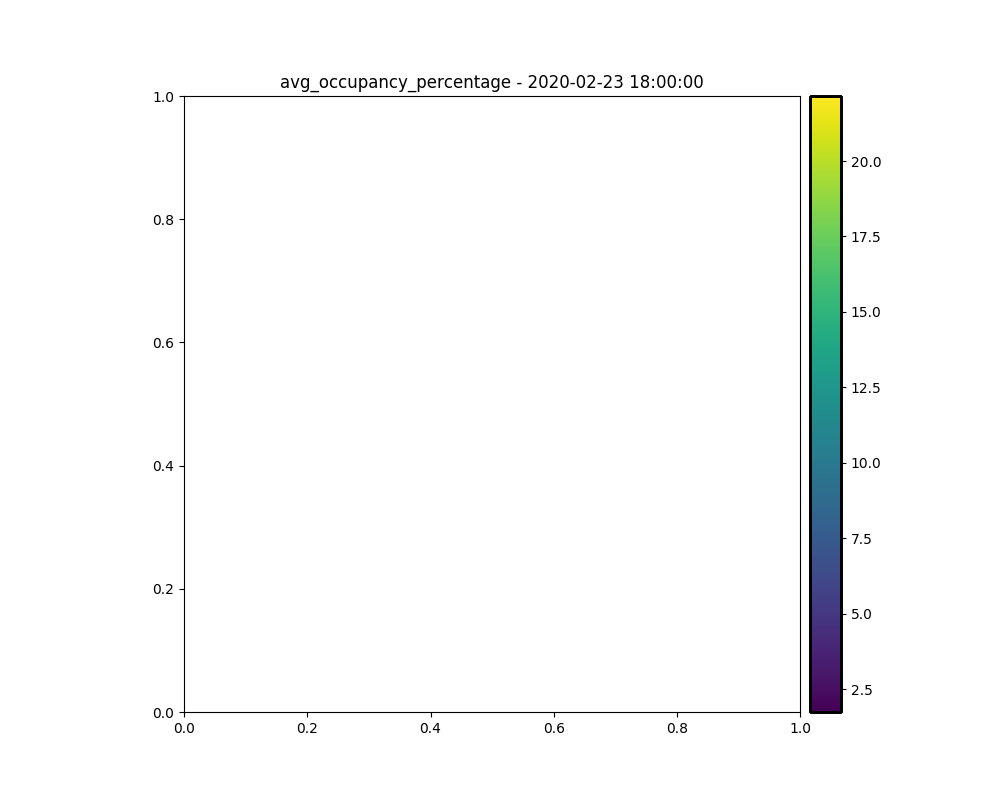

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
xdata, ydata = [], []

col = 'avg_occupancy_percentage'

norm = matplotlib.colors.Normalize(vmin=np.min(df[col]),vmax=np.max(df[col]))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

def init():
    ax.set_title(col+' - '+str(time_range[0]))
    df_tmp = df[df['measurement_start_utc']==time_range[0]]
    df_tmp.plot(column=col, figsize=(20, 10),ax=ax, norm=norm, legend=True, cax=cax)

def update(frame):
    ax.clear()
    ax.set_title(col+' - '+str(frame))
    df_tmp = df[df['measurement_start_utc']==frame]
    df_tmp.plot(column=col, figsize=(20, 10),ax=ax, norm=norm, legend=True, cax=cax)

ani = FuncAnimation(fig, update, frames=time_range, init_func=init)


In [13]:
# Set up formatting for the movie files
Writer = matplotlib.animation.FFMpegWriter
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

ani.save('im.mp4',  writer=writer)

2020-03-24 15:16:42     INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-03-24 15:16:42     INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x800', '-pix_fmt', 'rgba', '-r', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'im.mp4']
/Users/pohara/opt/anaconda3/envs/cleanair/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



In [14]:
from IPython.display import HTML
HTML(ani.to_jshtml())

2020-03-24 15:16:43     INFO: Animation.save using <class 'matplotlib.animation.HTMLWriter'>
/Users/pohara/opt/anaconda3/envs/cleanair/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

